<a href="https://colab.research.google.com/github/DeepakKumarSingh003/DataAnalytics-with-PandaSQL/blob/main/Data_Analytics_with_PandaSQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<b><u>Project:Identify valid clients by classifying the reason for their low or high Cibil Score.</u></b>

#Initial SET UP

In [1]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install SQlite & Pandasql
!pip install db-sqlite3
!pip install pandasql

# Importing Libraries
import pandas as pd
import sqlite3
from pandasql import sqldf
mysql = lambda q: sqldf(q, globals())


#Connection to DataBase
#To create a connection to the database in the current working directory
conn = sqlite3.connect('/content/drive/MyDrive/Projects/Cibil_score.db') 
#In order to execute SQL statements and fetch results from SQL queries, we will need to use a database cursor. 
c = conn.cursor()

# Get DataFrame
conn = sqlite3.connect('/content/drive/MyDrive/Projects/Cibil_score.db')
loan_info = pd.read_sql_query ('''SELECT * FROM loan_information''',conn)
enterprise_info = pd.read_sql_query ('''SELECT * FROM enterprise_information''',conn)
score_info = pd.read_sql_query ('''SELECT * FROM scores_information''',conn)
disbursement_info = pd.read_sql_query ('''SELECT * FROM disbursement_information''',conn)
merged_table=pd.read_sql_query('''select * from merged_table''', conn)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
# show first 5 table names from database
data = pd.read_sql_query('SELECT name from sqlite_master where type= "table";', conn) 
data.head()

,name
0,loan_information
1,enterprise_information
2,scores_information
3,disbursement_information
4,merged_table


In [83]:
#Drop merged_table from data base
conn.execute('''Drop table merged_table''')
conn.commit()

# show first 5 table names from database
data = pd.read_sql_query('SELECT name from sqlite_master where type= "table";', conn) 
data.head()

,name
0,loan_information
1,enterprise_information
2,scores_information
3,disbursement_information


# Understanding DATA

###Loan_Information
* loan_id	(int)	:- key for loan
* account_number(varchar)	:-key for account, generally you can assume that if there is no account number, the loan appication was rejected
* customer_id	(int)	:- key for customer
* enterprise_id	(int)	:-key for enterprise
* screening_date (date):-	when the loan was screened making an important initial decision point
* product_code	(varchar):-	type of product, if the last letter of product code is U it indicates unsecured product, if S then secured product
* hub_id	(int):-	which branch processed the loan

###Enterprise_Information
* enterprise_id	(int):-	key for enteprise
* business_type	(varchar):-	super category of business
* business_activity	(varchar):-	sub category of business sector
* business_sector	(varchar):-	sub category of business type

###Score_Information
* loan_id	(int):-	key for loan
* ManagAgeui_APP	(varchar):-	age of applicant
* BusinFormalityOfTheBusinessui	(varchar):-	whether applicant regularly uses a bank account and whether s/he takes money in cash or invoice
* ManagCBscoreui_APP	(varchar):-	applicant cibil score, -1 = no information whatsoever, 0 = less than 6 months, 650+ is considered good

###Disbursement_Information
* account_number	(varchar):-	key for account, generally you can assume that if there is no account number, the loan appication was rejected
* total_disbursement_amount	(int):-	total loan amount
* disbursement_month	(date):-	date loan amount transferred to customer

# Have a Glance at Tables and DATA in it.

In [84]:
display(mysql('''select count(*) as "********************Loan_information***********************" from loan_info limit 1'''),mysql('''select * from loan_info limit 5 '''),
        mysql('''select count(*) as "********************enterprise_information********************" from enterprise_info limit 1'''),mysql('''select  * from enterprise_info limit 5'''),
        mysql('''select count(*) as "********************score_information********************" from score_info limit 1'''),mysql('''select  * from score_info limit 5'''),
        mysql('''select count(*) as "********************disbursement_information*******************" from disbursement_info limit 1'''),mysql('''select  * from disbursement_info limit 5'''),
)


,********************Loan_information***********************
0,2476


,loan_id,account_number,customer_id,enterprise_id,screening_date,product_code,hub_id
0,29321,None,71846,24500.0,2018-04-19,None,53
1,13613,TLWCU0003070,31083,10723.0,2017-08-10,TLWCU,39
2,13921,None,31928,11002.0,2017-08-17,None,56
3,16520,None,38660,13220.0,2017-10-21,None,58
4,49742,TLWCS0012623,119694,40426.0,2018-12-24,TLWCS,27


,********************enterprise_information********************
0,2476


,loan_id,business_type,business_activity,business_sector,enterprise_id
0,29321,None,Job Work,Machine Components,24500.0
1,13613,Trading,Retail,Electronics,10723.0
2,13921,None,Retail,Agriculture,11002.0
3,16520,None,Retail,Food & Beverage,13220.0
4,49742,Manufacturing,Job Work & Sales,Textiles,40426.0


,********************score_information********************
0,2476


,loan_id,ManagAgeui_APP,BusinFormalityOfTheBusinessui,ManagCBscoreui_APP
0,29321,27.0,None,776.0
1,13613,30.0,Invoice & Banked,616.0
2,13921,55.0,None,793.0
3,16520,26.0,None,781.0
4,49742,30.0,Cash & Non Banked,689.0


,********************disbursement_information*******************
0,2476


,account_number,total_disbursement_amount,disbursement_month
0,None,NaN,None
1,TLWCU0003070,400000.0,Aug-2017
2,None,NaN,None
3,None,NaN,None
4,TLWCS0012623,500000.0,Jan-2019


###Observation
* ALL the tables have same number of rows (2476)
* Three out of 4 table can be join together to form one using loan_id of applicant.

#Joining tables together

In [85]:
# Load the data into a DataFrame
merged_df=pd.read_sql_query('''select l.loan_id,l.account_number as account_no,l.customer_id,l.screening_date,l.product_code,l.hub_id as branch_id,
e.business_type ,e.business_activity,e.business_sector,s.ManagAgeui_APP as age,s.BusinFormalityOfTheBusinessui as cash_or_invoice,
s.ManagCBscoreui_APP as cibil_score
from loan_information as l inner join enterprise_information as e on l.loan_id=e.loan_id
inner join scores_information as s on l.loan_id=s.loan_id
''',conn,index_col=None)

# Write records stored in a DataFrame to a SQL database.
merged_df.to_sql("merged_table", conn, if_exists="replace",index=False)

#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query('''select * from merged_table''', conn)

#On the connection object to commit the transaction:
conn.commit()



In [86]:
mysql('''select * from merged_table limit 5''')

,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score
0,29321,None,71846,2018-04-19,None,53,None,Job Work,Machine Components,27.0,None,776.0
1,13613,TLWCU0003070,31083,2017-08-10,TLWCU,39,Trading,Retail,Electronics,30.0,Invoice & Banked,616.0
2,13921,None,31928,2017-08-17,None,56,None,Retail,Agriculture,55.0,None,793.0
3,16520,None,38660,2017-10-21,None,58,None,Retail,Food & Beverage,26.0,None,781.0
4,49742,TLWCS0012623,119694,2018-12-24,TLWCS,27,Manufacturing,Job Work & Sales,Textiles,30.0,Cash & Non Banked,689.0


#Feature Engineering

###Unique Values



In [87]:
#count distinct values for each feature
mysql('''select count(distinct(loan_id)) as cnt_load_id,count(distinct(account_no)) as cnt_acc_no,count(distinct(customer_id)) as cnt_custmer_id,
count(distinct(screening_date)) as cnt_screening_date,count(distinct(product_code)) as cnt_product_code,count(distinct(branch_id)) as cnt_branch_code,
count(distinct(business_type)) as cnt_businss_type,count(distinct(business_activity)) as cnt_business_activity,
count(distinct(business_sector)) as cnt_business_sect,count(distinct(age)) as cnt_age,
count(distinct(cash_or_invoice)) as cnt_cash_or_invoice,count(distinct(cibil_score)) as cnt_cibil_score
from merged_table
''')

,cnt_load_id,cnt_acc_no,cnt_custmer_id,cnt_screening_date,cnt_product_code,cnt_branch_code,cnt_businss_type,cnt_business_activity,cnt_business_sect,cnt_age,cnt_cash_or_invoice,cnt_cibil_score
0,2476,1369,2443,682,16,90,4,9,38,48,4,306


## Check on Nulls

In [88]:
#Total values vs nulls vs Not nulls
display(mysql('''select count(*) as account_no,count(case when account_no is null then 0 end) as null_cnt,count(case when account_no is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as customer_id,count(case when customer_id is null then 0 end) as null_cnt,count(case when customer_id is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as screening_date,count(case when screening_date is null then 0 end) as null_cnt,count(case when screening_date is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as product_code,count(case when product_code is null then 0 end) as null_cnt,count(case when product_code is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as branch_id,count(case when branch_id is null then 0 end) as null_cnt,count(case when branch_id is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as business_type,count(case when business_type is null then 0 end) as null_cnt,count(case when business_type is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as business_activity,count(case when business_activity is null then 0 end) as null_cnt,count(case when business_activity is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as business_sector,count(case when business_sector is null then 0 end) as null_cnt,count(case when business_sector is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as age,count(case when age is null then 0 end) as null_cnt,count(case when age is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as cash_or_invoice,count(case when cash_or_invoice is null then 0 end) as null_cnt,count(case when cash_or_invoice is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as cibil_score,count(case when cibil_score is null then 0 end) as null_cnt,count(case when cibil_score is not null then 1 end) as not_null_cnt
 from merged_table'''))

,account_no,null_cnt,not_null_cnt
0,2476,1107,1369


,customer_id,null_cnt,not_null_cnt
0,2476,0,2476


,screening_date,null_cnt,not_null_cnt
0,2476,126,2350


,product_code,null_cnt,not_null_cnt
0,2476,1058,1418


,branch_id,null_cnt,not_null_cnt
0,2476,0,2476


,business_type,null_cnt,not_null_cnt
0,2476,463,2013


,business_activity,null_cnt,not_null_cnt
0,2476,1,2475


,business_sector,null_cnt,not_null_cnt
0,2476,1,2475


,age,null_cnt,not_null_cnt
0,2476,3,2473


,cash_or_invoice,null_cnt,not_null_cnt
0,2476,488,1988


,cibil_score,null_cnt,not_null_cnt
0,2476,3,2473


#Handling Missing values
###Using SQLite 
* we have missing values mostly in categorical data.
* For missing value imputation is categorical data it is advisable to impute with mode category which have significantly higher frequency for missing value less than or equal to 5%
* But if we missing values more than 10% than we can create a new category for missing values
* these both are the simple approches and sometimes effect also
* lets explore other techniques as well

###Handling missing values in Account Number

In [89]:
# Application rejected vs accepted
display(mysql('''select "Loan application rejected" limit 0'''),mysql('''select * from merged_table
where account_no isnull 
 '''),mysql('''select "Loan application accepted" limit 0'''),mysql('''select * from merged_table
where account_no is not null 
 '''))

,"""Loan application rejected"""


,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score
0,29321,None,71846,2018-04-19,None,53,None,Job Work,Machine Components,27.0,None,776.0
1,13921,None,31928,2017-08-17,None,56,None,Retail,Agriculture,55.0,None,793.0
2,16520,None,38660,2017-10-21,None,58,None,Retail,Food & Beverage,26.0,None,781.0
3,59718,None,12095,2019-04-17,None,25,Trading,Retail,Houseware,29.0,Cash & Banked,757.0
4,37403,None,91252,2018-08-21,None,98,Trading,Whole Sale,Fashion,42.0,Cash & Non Banked,539.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1102,27124,None,66733,2018-03-13,None,48,None,Retail,Food & Beverage,46.0,None,716.0
1103,26272,None,64792,2018-03-04,None,19,None,Retail,General,32.0,None,701.0
1104,13462,None,7058,2017-08-07,None,42,Manufacturing,Job Work & Sales,Plastics,39.0,None,528.0
1105,15639,None,36377,2017-09-23,None,42,None,Job Work & Sales,Wood,49.0,Cash & Non Banked,536.0


,"""Loan application accepted"""


,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score
0,13613,TLWCU0003070,31083,2017-08-10,TLWCU,39,Trading,Retail,Electronics,30.0,Invoice & Banked,616.0
1,49742,TLWCS0012623,119694,2018-12-24,TLWCS,27,Manufacturing,Job Work & Sales,Textiles,30.0,Cash & Non Banked,689.0
2,65458,TLWCS0016745,150404,2019-06-26,TLWCS,41,Manufacturing,Sales,Rubber,49.0,Invoice & Non Banked,793.0
3,20064,TLWCS0002705,49773,2017-11-17,TLWCS,34,Manufacturing,Sales,Plastics,34.0,Invoice & Banked,718.0
4,4378,0014LTL2000211,6640,None,TLWCU,20,Trading,Retail,Fashion,46.0,Cash & Non Banked,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1364,40403,TLWCS0009988,97765,2018-09-21,TLWCS,51,Trading,Retail,Fashion,40.0,Cash & Non Banked,0.0
1365,58638,TLWCS0015005,137774,2019-03-29,TLWCS,35,Trading,Whole Sale,Construction,29.0,Cash & Non Banked,697.0
1366,14122,TLWCS0001490,32442,2017-08-21,TLWCS,40,Manufacturing,Job Work,Auto Components,43.0,Cash & Non Banked,760.0
1367,3420,0007LTL1004271,10054,None,TLWCS,15,Manufacturing,Job Work,Auto Components,28.0,Invoice & Banked,802.0


***Observation***
* From the defination given total 1107 loan appliactions were already rejected.
* lets do some brain stroming over those applicant who does not  have account number and try to extract usefull rows from them as well
* Directly removing them all is not justice to dataset. 
  

**Rejected and Cibil Score below minimum threshold**
* Need to remove this rows as they may be more risky. 

In [90]:
#Dont have account detaila and also low cibil score 
mysql('''select * from merged_table
where account_no isnull and cibil_score<650''')

,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score
0,37403,None,91252,2018-08-21,None,98,Trading,Whole Sale,Fashion,42.0,Cash & Non Banked,539.0
1,35718,None,87390,2018-08-06,None,33,None,Job Work & Sales,Fabrication,44.0,None,585.0
2,14242,None,32762,2017-08-23,None,36,None,Job Work & Sales,Machine Components,39.0,None,544.0
3,22424,None,19574,2018-01-06,None,26,Manufacturing,Job Work & Sales,Fabrication,39.0,Invoice & Banked,622.0
4,35332,None,86471,2018-07-26,None,56,Manufacturing,Job Work & Sales,Machine Components,37.0,Cash & Non Banked,535.0
...,...,...,...,...,...,...,...,...,...,...,...,...
470,56889,None,134663,2019-03-13,None,64,Trading,Retail,Food & Beverage,50.0,None,564.0
471,57703,None,86391,2019-03-20,None,42,Manufacturing,Job Work & Sales,Metal works,30.0,Cash & Non Banked,0.0
472,52493,None,125729,2019-01-21,None,71,Trading,Whole Sale,Electricals,36.0,Cash & Non Banked,544.0
473,13462,None,7058,2017-08-07,None,42,Manufacturing,Job Work & Sales,Plastics,39.0,None,528.0


**Delete rows**

In [91]:
#In order to execute SQL statements and fetch results from SQL queries, we will need to use a database cursor.
cur = conn.cursor()
cur.execute("Delete from merged_table where account_no isnull and cibil_score<650")
conn.commit()


In [92]:
#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query("select * from merged_table;", conn)
conn.commit()

In [93]:
#check if any left
mysql('''select * from merged_table
where account_no isnull and cibil_score<650''')

,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score


**Check for Duplicates in customer_id**

In [94]:
#Duplicate customer
mysql('''select customer_id,count(customer_id) from merged_table
group by customer_id
having count(customer_id)>1
order by customer_id
''')

,customer_id,count(customer_id)
0,6746,2
1,7136,2
2,7167,2
3,7189,3
4,7454,2
5,8120,2
6,8357,3
7,8481,2
8,8982,2
9,9631,2


In [95]:
# Customers who have cibil score lower than 650 and are duplicate in customer id and also don't have account number
mysql('''with dups as (select customer_id,count(customer_id) from merged_table
group by customer_id
having count(customer_id)>1)
select * from merged_table where customer_id in (select customer_id from dups order by customer_id ) and account_no is null and
cibil_score<650 order by customer_id  
''')

,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score


***Observation***
* It may happen that a same customer have taken loan second time after some interval of time.
* hence no need to remove all the duplicates.
* Also most risky client already eliminated after performing cleaning on account_no.


In [96]:
#columns only
mysql('''select * from merged_table limit 0''')

,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score


###**Screening date**


In [97]:
#Top 20 screening date
mysql('''select screening_date,count(screening_date) as count from merged_table
group by screening_date
order by count(screening_date) desc
limit 20
''')

,screening_date,count
0,2018-08-14,11
1,2019-01-22,11
2,2018-01-19,10
3,2019-04-12,10
4,2018-10-16,9
5,2018-12-19,9
6,2019-01-19,9
7,2019-02-12,9
8,2019-03-16,9
9,2018-03-07,8


***Observation***
* We have a small pattern that mostly higher frequency date have months like december and jan this could be a assumption but we need to work to prove it right
* Imputing with most frequent date may hamper our decision.
* With hard heart I have to scarifies null in time. 

In [98]:
#Delete nulls from screening date
cur = conn.cursor()
cur.execute("Delete from merged_table where screening_date isnull")
conn.commit()

In [99]:
#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query("select * from merged_table;", conn)
conn.commit()

###**Product Code**
* As per defination code with last letter as U are unsafe and last letter as S are safe product.
* Lets categorise it as safe and unsafe
* it has nulls more than 10% so better create a new category with null 

In [100]:
mysql('''select distinct(product_code) from merged_table''')

,product_code
0,None
1,TLWCU
2,TLWCS
3,TLAPS
4,LCRDS
5,TLBDU
6,ICWCS
7,VCWCS
8,LCRDU
9,STWCU


In [101]:
#Set 2 for safe product, 0 for unsafe product and 1 for unknown
cur.execute("update merged_table set product_code= 2 where product_code like '%S'")
cur.execute("update merged_table set product_code= 0 where product_code like '%U'")
cur.execute("update merged_table set product_code= 1 where product_code is null ")
conn.commit()

In [102]:
#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query("select * from merged_table;", conn)
conn.commit()

In [103]:
mysql('''select product_code,count(product_code) as count from merged_table group by product_code''')

,product_code,count
0,0,556
1,1,592
2,2,727


###**Branch score**
* Great we don't have any null in it.
* lets Check for branch which are performing better.


In [104]:
#Top 10 best performing branches
mysql('''select branch_id,count(branch_id) from merged_table
where cibil_score>650
group by branch_id
order by count(branch_id) desc
limit 10''')

,branch_id,count(branch_id)
0,37,38
1,35,36
2,15,34
3,28,33
4,17,32
5,33,32
6,25,29
7,40,29
8,39,28
9,18,27


###**Business type**
* I think there might be effect of removing null screening date on business type.

In [105]:
mysql('''select count(*) as count from merged_table''')

,count
0,1875


In [106]:
mysql('''select business_type,count(business_type) from merged_table
group by business_type''')

,business_type,count(business_type)
0,None,0
1,Manufacturing,899
2,Services,8
3,Trading,727


***Observation***
* We are good to go for business_type
* But there is imbalance in service so lets merge both as Servise & Trading

In [107]:
mysql('''select count(*) as count from merged_table where business_type is null''')

,count
0,241


**Update**

In [108]:
#update feature
cur = conn.cursor()
cur.execute("update merged_table set business_type='Trading' where business_type='Services' ")
cur.execute("update merged_table set business_type = 'Unknown' where business_type is null ")
conn.commit()

In [109]:
#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query("select * from merged_table;", conn)
conn.commit()

In [110]:
mysql('''select business_type,count(business_type) from merged_table
group by business_type''')

,business_type,count(business_type)
0,Manufacturing,899
1,Trading,735
2,Unknown,241


###**Business Activity**

In [111]:
mysql('''select business_activity,count(business_activity) as count from merged_table 
group by business_activity''')

,business_activity,count
0,Job Work,231
1,Job Work & Sales,355
2,Retail,567
3,Retail (Business to Business),3
4,Retail (Business to Customer),5
5,Sales,423
6,Whole Sale,291


**Update**

In [112]:
#Merge Retail B2B and B2C in Retail 
cur = conn.cursor()
cur.execute("update merged_table set business_activity='Retail' where business_activity in ('Retail (Business to Business)',	'Retail (Business to Customer)') ")
conn.commit()

In [113]:
#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query("select * from merged_table;", conn)
conn.commit()

In [114]:
#Updated
mysql('''select business_activity,count(business_activity) as count from merged_table 
group by business_activity''')

,business_activity,count
0,Job Work,231
1,Job Work & Sales,355
2,Retail,575
3,Sales,423
4,Whole Sale,291


###**Business Sector**

In [115]:
mysql('''select business_sector,count(business_sector) as count from merged_table 
group by business_sector''')

,business_sector,count
0,Agriculture,15
1,Apparel,22
2,Auto Components,149
3,Automobiles,53
4,Bedding,3
5,Bedding Industry,5
6,Book Stores,4
7,Chemicals,31
8,Construction,49
9,Construction Material,6


***Observation***
* Cobined Sectors
   * Agriculture
   * Wood=wood,Rubber,Papper
   * General=Book_store,general,hobbies,printing
   * Clothing=Apparel,Fashion,Handicraft
   * Industrial=Chemical,Leather,Textile,Industrial,Machine Component,metal Work, Plastic,Fabrication
   * Automobile=Auto Components,Automobiles
   * Furniture=Bedding,Bedding Industry,Furniture,Home Furnishings,Houseware
   * Construction=Construction,construction Material
   * Electrical=Electrical,Electricals,Electronics	
   * Food=Food & Beverage,Food Product
   * Health=Heath & Beauty, Pharmaceuticals
     * Note:- I have used internet and some common knowledge for comining available sectors.

In [116]:
cur = conn.cursor()
cur.execute("update merged_table set business_sector='Wood' where business_sector in ('Rubber','Wood','Paper') ")
cur.execute("update merged_table set business_sector='General' where business_sector in ('General','Printing','Book Stores','Hobbies') ")
cur.execute("update merged_table set business_sector='Cloths' where business_sector in ('Apparel','Fashion') ")
cur.execute("update merged_table set business_sector='Industrial' where business_sector in ('Industrial','Chemicals','Leather','Textiles','Plastics','Fabrication','Machine Components','Metal works') ")
cur.execute("update merged_table set business_sector='Construction' where business_sector in ('Construction',	'Construction Material') ")
cur.execute("update merged_table set business_sector='Furniture' where business_sector in ('Bedding','Bedding Industry','Furniture','Home Furnishings','Houseware')")
cur.execute("update merged_table set business_sector='Automobiles' where business_sector in ('Automobiles','Auto Components') ")
cur.execute("update merged_table set business_sector='Electrical' where business_sector in ('Electrical','Electricals','Electronics') ")
cur.execute("update merged_table set business_sector='Food' where business_sector in ('Food & Beverage','Food Products') ")
cur.execute("update merged_table set business_sector='Health' where business_sector in ('Medical Equipment','Pharmaceuticals','Health & Beauty') ")
conn.commit()

In [117]:
#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query("select * from merged_table;", conn)
conn.commit()

In [118]:
mysql('''select business_sector,count(business_sector) as count from merged_table 
group by business_sector''')

,business_sector,count
0,Agriculture,15
1,Automobiles,202
2,Cloths,266
3,Construction,55
4,Electrical,105
5,Food,285
6,Furniture,62
7,General,59
8,Handicrafts,32
9,Health,37


###**Age**

In [119]:
#Check if any outlier in the age 
display(mysql('''select max(age),min(age),round(avg(age),1) as mean from merged_table'''),
        mysql('''select age as mode,count(*) as count from merged_table group by age order by count desc limit 1'''))

,max(age),min(age),mean
0,66.0,20.0,38.2


,mode,count
0,34.0,99


**Updating rows**
* We can modify rows in a SQLite table using the execute method:



In [120]:
#Fill missing value in age with mean as we dont have any outliers
cur = conn.cursor()
cur.execute("update merged_table set age=38 where age is null")
conn.commit()

In [121]:
#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query("select * from merged_table;", conn)
conn.commit()

In [122]:
mysql('''select * from merged_table''')

,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score
0,29321,None,71846,2018-04-19,1,53,Unknown,Job Work,Machine Components,27.0,None,776.0
1,13613,TLWCU0003070,31083,2017-08-10,0,39,Trading,Retail,Electrical,30.0,Invoice & Banked,616.0
2,13921,None,31928,2017-08-17,1,56,Unknown,Retail,Agriculture,55.0,None,793.0
3,16520,None,38660,2017-10-21,1,58,Unknown,Retail,Food,26.0,None,781.0
4,49742,TLWCS0012623,119694,2018-12-24,2,27,Manufacturing,Job Work & Sales,Industrial,30.0,Cash & Non Banked,689.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1870,40403,TLWCS0009988,97765,2018-09-21,2,51,Trading,Retail,Cloths,40.0,Cash & Non Banked,0.0
1871,58638,TLWCS0015005,137774,2019-03-29,2,35,Trading,Whole Sale,Construction,29.0,Cash & Non Banked,697.0
1872,14122,TLWCS0001490,32442,2017-08-21,2,40,Manufacturing,Job Work,Automobiles,43.0,Cash & Non Banked,760.0
1873,42491,TLWCU0010873,102464,2018-10-15,0,32,Manufacturing,Sales,Industrial,53.0,Invoice & Banked,773.0


###**Cash or Invoice**

In [123]:
mysql('''select cash_or_invoice,count(cash_or_invoice) from merged_table group by cash_or_invoice''')

,cash_or_invoice,count(cash_or_invoice)
0,None,0
1,Cash & Banked,73
2,Cash & Non Banked,1223
3,Invoice & Banked,208
4,Invoice & Non Banked,133


In [124]:
mysql('''select count(*) as count from merged_table where cash_or_invoice is null''')

,count
0,238


In [125]:
cur = conn.cursor()
cur.execute("update merged_table set cash_or_invoice='Unknown' where cash_or_invoice is null")
conn.commit()

In [126]:
#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query("select * from merged_table;", conn)
conn.commit()

In [127]:
mysql('''select * from merged_table''')

,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score
0,29321,None,71846,2018-04-19,1,53,Unknown,Job Work,Machine Components,27.0,Unknown,776.0
1,13613,TLWCU0003070,31083,2017-08-10,0,39,Trading,Retail,Electrical,30.0,Invoice & Banked,616.0
2,13921,None,31928,2017-08-17,1,56,Unknown,Retail,Agriculture,55.0,Unknown,793.0
3,16520,None,38660,2017-10-21,1,58,Unknown,Retail,Food,26.0,Unknown,781.0
4,49742,TLWCS0012623,119694,2018-12-24,2,27,Manufacturing,Job Work & Sales,Industrial,30.0,Cash & Non Banked,689.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1870,40403,TLWCS0009988,97765,2018-09-21,2,51,Trading,Retail,Cloths,40.0,Cash & Non Banked,0.0
1871,58638,TLWCS0015005,137774,2019-03-29,2,35,Trading,Whole Sale,Construction,29.0,Cash & Non Banked,697.0
1872,14122,TLWCS0001490,32442,2017-08-21,2,40,Manufacturing,Job Work,Automobiles,43.0,Cash & Non Banked,760.0
1873,42491,TLWCU0010873,102464,2018-10-15,0,32,Manufacturing,Sales,Industrial,53.0,Invoice & Banked,773.0


###**Cibil Score**

In [128]:
mysql('''select cibil_score,count(cibil_score) as count from merged_table group by cibil_score order by count(cibil_score) desc''')

,cibil_score,count
0,0.0,190
1,802.0,120
2,817.0,107
3,793.0,100
4,812.0,75
...,...,...
252,825.0,1
253,828.0,1
254,831.0,1
255,840.0,1


In [129]:
mysql('''select count(*) as count from merged_table where cibil_score is null''')

,count
0,2


In [130]:
display(mysql('''select count(*) as total from merged_table'''),mysql('''select count(*) as above_650 from merged_table where cibil_score>650'''),
mysql('''select count(*) as below_650 from merged_table where cibil_score<650'''))

,total
0,1875


,above_650
0,1558


,below_650
0,310


In [131]:
cur = conn.cursor()
cur.execute("update merged_table set cibil_score=0 where cibil_score is null")
conn.commit()

In [132]:
#Read SQL query into a DataFrame.
merged_table=pd.read_sql_query("select * from merged_table;", conn)
conn.commit()

In [133]:
mysql('''select * from merged_table limit 3''')

,loan_id,account_no,customer_id,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score
0,29321,None,71846,2018-04-19,1,53,Unknown,Job Work,Machine Components,27.0,Unknown,776.0
1,13613,TLWCU0003070,31083,2017-08-10,0,39,Trading,Retail,Electrical,30.0,Invoice & Banked,616.0
2,13921,None,31928,2017-08-17,1,56,Unknown,Retail,Agriculture,55.0,Unknown,793.0


In [134]:
mysql('''select cibil_score,count(cibil_score) from merged_table group by cibil_score''')

,cibil_score,count(cibil_score)
0,0.0,192
1,514.0,1
2,518.0,1
3,528.0,1
4,529.0,1
...,...,...
251,828.0,1
252,831.0,1
253,833.0,4
254,836.0,2


In [135]:
#Total values vs nulls vs Not nulls
display(mysql('''select count(*) as account_no,count(case when account_no is null then 0 end) as null_cnt,count(case when account_no is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as customer_id,count(case when customer_id is null then 0 end) as null_cnt,count(case when customer_id is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as screening_date,count(case when screening_date is null then 0 end) as null_cnt,count(case when screening_date is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as product_code,count(case when product_code is null then 0 end) as null_cnt,count(case when product_code is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as branch_id,count(case when branch_id is null then 0 end) as null_cnt,count(case when branch_id is not null then 1 end) as not_null_cnt
 from merged_table'''),
mysql('''select count(*) as business_type,count(case when business_type is null then 0 end) as null_cnt,count(case when business_type is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as business_activity,count(case when business_activity is null then 0 end) as null_cnt,count(case when business_activity is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as business_sector,count(case when business_sector is null then 0 end) as null_cnt,count(case when business_sector is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as age,count(case when age is null then 0 end) as null_cnt,count(case when age is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as cash_or_invoice,count(case when cash_or_invoice is null then 0 end) as null_cnt,count(case when cash_or_invoice is not null then 1 end) as not_null_cnt
 from merged_table'''),
 mysql('''select count(*) as cibil_score,count(case when cibil_score is null then 0 end) as null_cnt,count(case when cibil_score is not null then 1 end) as not_null_cnt
 from merged_table'''))

,account_no,null_cnt,not_null_cnt
0,1875,632,1243


,customer_id,null_cnt,not_null_cnt
0,1875,0,1875


,screening_date,null_cnt,not_null_cnt
0,1875,0,1875


,product_code,null_cnt,not_null_cnt
0,1875,0,1875


,branch_id,null_cnt,not_null_cnt
0,1875,0,1875


,business_type,null_cnt,not_null_cnt
0,1875,0,1875


,business_activity,null_cnt,not_null_cnt
0,1875,0,1875


,business_sector,null_cnt,not_null_cnt
0,1875,0,1875


,age,null_cnt,not_null_cnt
0,1875,0,1875


,cash_or_invoice,null_cnt,not_null_cnt
0,1875,0,1875


,cibil_score,null_cnt,not_null_cnt
0,1875,0,1875


#Exploratory Data Analysis 

###With pandas,matplotlib and seaborn

In [136]:
#Import important libraries which we are going to use for the EDA.
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.style.use('ggplot') #to have ggplot like style
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [137]:
final_df=mysql('''select screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score	  from merged_table''')
final_df.head()

,screening_date,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score
0,2018-04-19,1,53,Unknown,Job Work,Machine Components,27.0,Unknown,776.0
1,2017-08-10,0,39,Trading,Retail,Electrical,30.0,Invoice & Banked,616.0
2,2017-08-17,1,56,Unknown,Retail,Agriculture,55.0,Unknown,793.0
3,2017-10-21,1,58,Unknown,Retail,Food,26.0,Unknown,781.0
4,2018-12-24,2,27,Manufacturing,Job Work & Sales,Industrial,30.0,Cash & Non Banked,689.0


In [138]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   screening_date     1875 non-null   object 
 1   product_code       1875 non-null   object 
 2   branch_id          1875 non-null   int64  
 3   business_type      1875 non-null   object 
 4   business_activity  1875 non-null   object 
 5   business_sector    1875 non-null   object 
 6   age                1875 non-null   float64
 7   cash_or_invoice    1875 non-null   object 
 8   cibil_score        1875 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 132.0+ KB


##Features Transformation
* Convert age and cibil_score into int type from float type.



In [139]:
#Convert product_code,age,cibil_score into int type
final_df['product_code'] = final_df['product_code'].apply(lambda x: int(x))
final_df['age'] = final_df['age'].apply(lambda x: int(x))
final_df['cibil_score'] = final_df['cibil_score'].apply(lambda x: int(x))


**Convert to pandas date time** 

In [140]:
# convert it into pandas dataframe and extract month and dayofweek
final_df['month'] = pd.DatetimeIndex(final_df['screening_date']).month
final_df["day_ofweek"] = pd.DatetimeIndex(final_df['screening_date']).dayofweek
final_df.drop(['screening_date'],axis=1,inplace=True)

In [141]:
final_df.head()

,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score,month,day_ofweek
0,1,53,Unknown,Job Work,Machine Components,27,Unknown,776,4,3
1,0,39,Trading,Retail,Electrical,30,Invoice & Banked,616,8,3
2,1,56,Unknown,Retail,Agriculture,55,Unknown,793,8,3
3,1,58,Unknown,Retail,Food,26,Unknown,781,10,5
4,2,27,Manufacturing,Job Work & Sales,Industrial,30,Cash & Non Banked,689,12,0


***Observation***
* having  month and day of week in our data set give extensive information about the trend of cilient.

##Categorise cibil score as 1 for score above 650 and 0 for below 650 

In [142]:
# converting genres object into list of genres
final_df['cibil_score'] = final_df['cibil_score'].apply(lambda x: x*0 if x < 650 else (x*0)+1)
final_df.cibil_score.value_counts()

1    1563
0     312
Name: cibil_score, dtype: int64

**Countplot for categorical features.**

In [143]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_code       1875 non-null   int64 
 1   branch_id          1875 non-null   int64 
 2   business_type      1875 non-null   object
 3   business_activity  1875 non-null   object
 4   business_sector    1875 non-null   object
 5   age                1875 non-null   int64 
 6   cash_or_invoice    1875 non-null   object
 7   cibil_score        1875 non-null   int64 
 8   month              1875 non-null   int64 
 9   day_ofweek         1875 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 146.6+ KB


##Univariate Analysis

product_code


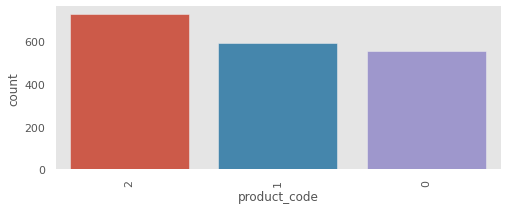

business_type


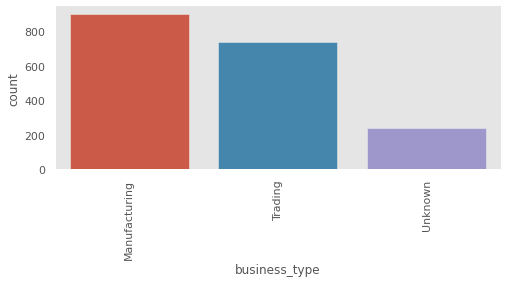

business_activity


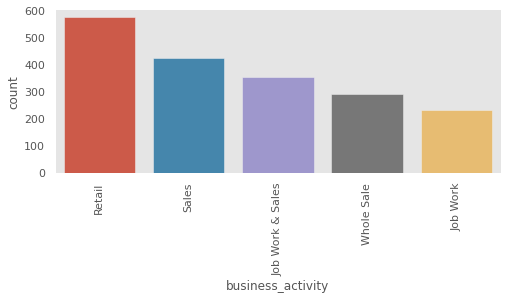

business_sector


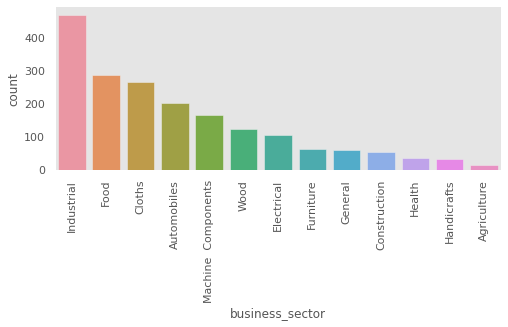

cash_or_invoice


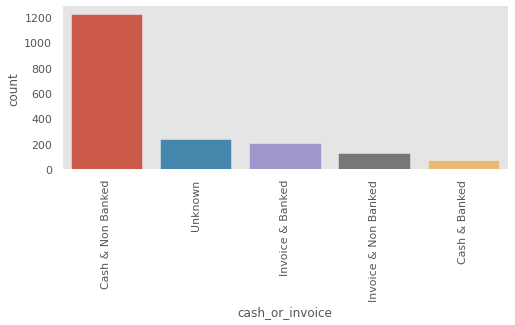

month


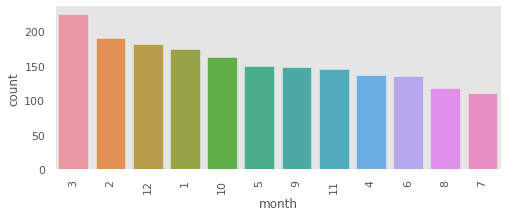

day_ofweek


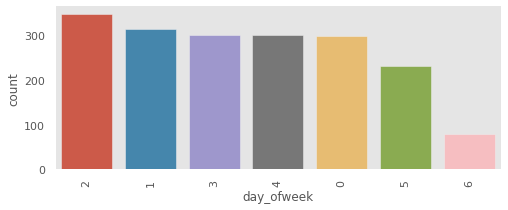

In [144]:
#Univariate categorical analysis
for i in final_df[["product_code",	"business_type", "business_activity","business_sector","cash_or_invoice","month","day_ofweek"]]:
  print(i)
  fig, ax = plt.subplots(figsize=(8, 3))
  sns.countplot(data=final_df,x=i,ax=ax,order = final_df[i].value_counts().index)
  sns.despine()
  plt.grid(False)
  plt.xticks(rotation=90)
  plt.show()

***Observation***
* cash_or_invoice feature is imbalance categories needs further more exploration.
* There are some values at 6 of day_ofweek which indicate processes are ongoing on sundays as well.

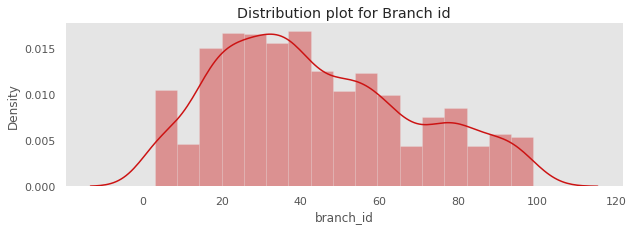

In [145]:
# Distribution plot
fig, ax = plt.subplots(figsize=(10, 3))
sns.distplot(a=final_df['branch_id'],color='#CC1313',label="100% Equities",kde=True,ax=ax)
plt.title("Distribution plot for Branch id")
sns.despine()
plt.grid(False)
plt.show()


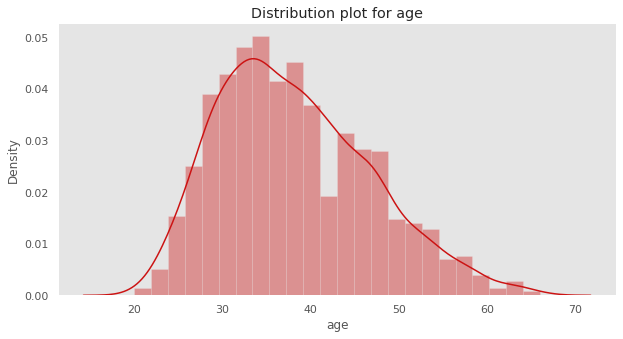

In [146]:
# Distribution plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(a=final_df['age'],color='#CC1313',label="100% Equities",kde=True,ax=ax)
plt.title("Distribution plot for age")
sns.despine()
plt.grid(False)
plt.show()



***Observation***
* Age feature is approx normally distributed.


##Outliers

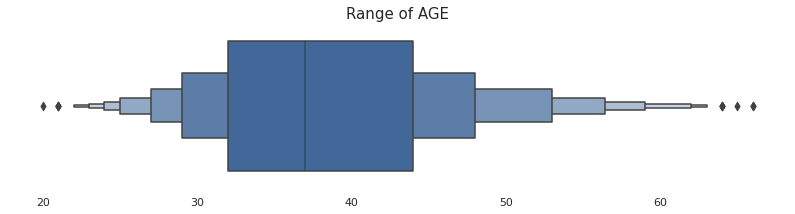

In [147]:
#BoxPlot to check outliers 
sns.set_theme(rc={'figure.figsize': (14,3)},style='whitegrid')
sns.boxenplot(x=final_df['age'],color='#3266a8')
plt.grid(False)
plt.xlabel('')
plt.title('Range of AGE',size=15)
ax = plt.gca()
for spine in ax.spines.values():
   spine.set_visible(False)

In [148]:
def out_iqr(df , column):
  '''This Function gives IQR value lower bound and upper bound value
  and count the total outliers in numerical and in percentage
  '''
  q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
  # calculate the IQR
  iqr = q75 - q25
  # calculate the outlier cutoff
  cut_off = iqr * 1.5
  # calculate the lower and upper bound value
  lower, upper = q25 - cut_off, q75 + cut_off
  print('The IQR is',iqr)
  print('The lower bound value is', lower)
  print('The upper bound value is', upper)
  # Calculate the number of records below and above lower and above bound value respectively
  df1 = df[df[column] > upper]
  df2 = df[df[column] < lower]
  perc=(df1.shape[0]+ df2.shape[0]/len(df[column]))
  return print('Total number of outliers are',df1.shape[0]+ df2.shape[0],"In percentage",((df1.shape[0]+ df2.shape[0])*100/len(df[column])))

In [149]:
#outliers
out_iqr(final_df,"age")

The IQR is 12.0
The lower bound value is 14.0
The upper bound value is 62.0
Total number of outliers are 13 In percentage 0.6933333333333334


***Observation***
* Thses outliers doest seem to any adverse effect on model.

###Bivariate analysis
* Categorical Features with Target

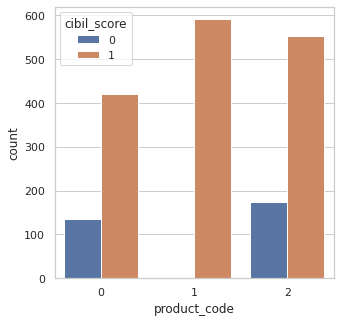

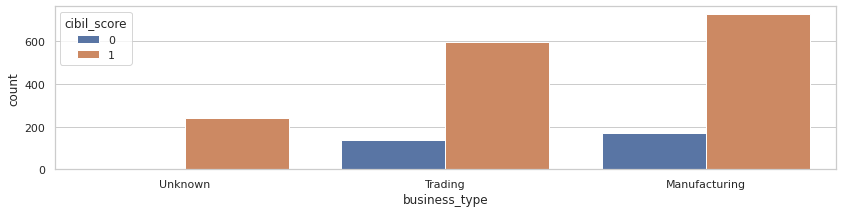

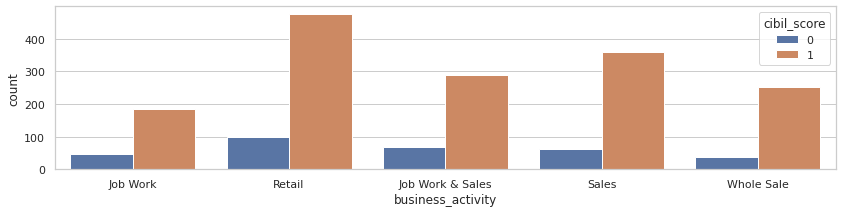

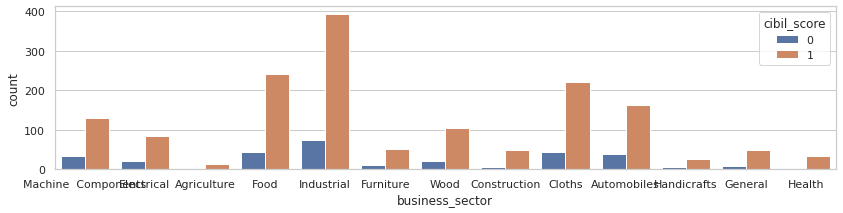

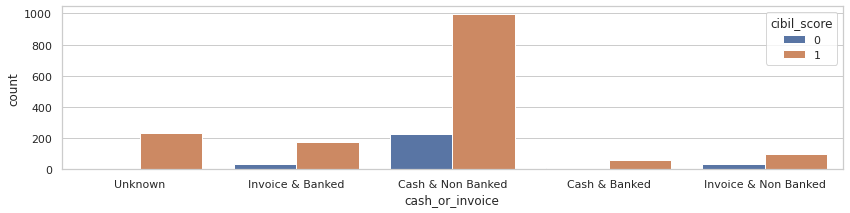

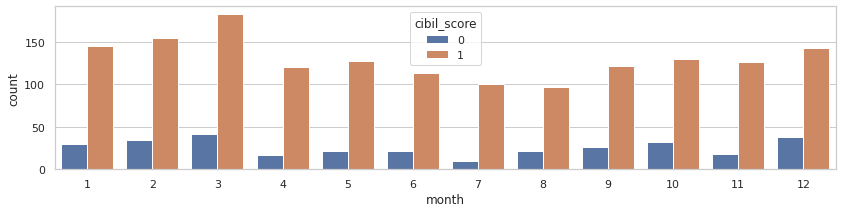

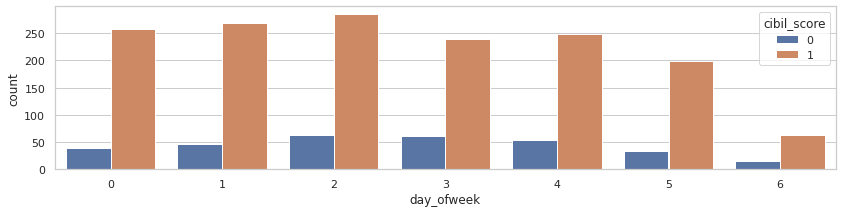

In [150]:
#countPlot for Categorical features
    
plt.figure(figsize=(5,5))
for i in final_df[["product_code","business_type", "business_activity","business_sector","cash_or_invoice","month","day_ofweek"]]:
  sns.countplot(x=i,data=final_df,hue="cibil_score")
  plt.show()

***Observation***
* mostly screening is done in the month of December,Jan,Feb and March it was our assumption also which is supported by bar graph.
* Clients from Industries, clothing sector and food business have higher sucess rate.

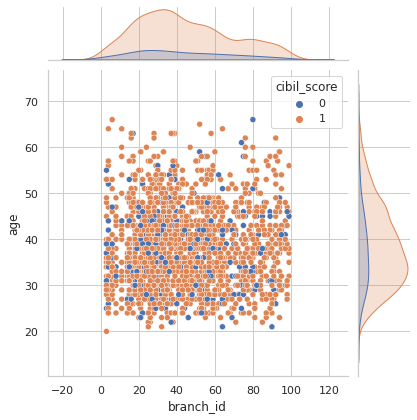

In [151]:
sns.jointplot(x='branch_id',y='age',data=final_df,hue="cibil_score",kind="scatter")
plt.show()

***Observation***
* All the branches have account for different age groups hence branches are not baised towards age group.
* As assumed age groups above 25 and below 55 have maximun clients.

#Encoding Categorical features
* We have only Nominal categories.
* Hence we will use one hot encoding for encoding categorical features. 

In [152]:
final_df

,product_code,branch_id,business_type,business_activity,business_sector,age,cash_or_invoice,cibil_score,month,day_ofweek
0,1,53,Unknown,Job Work,Machine Components,27,Unknown,1,4,3
1,0,39,Trading,Retail,Electrical,30,Invoice & Banked,0,8,3
2,1,56,Unknown,Retail,Agriculture,55,Unknown,1,8,3
3,1,58,Unknown,Retail,Food,26,Unknown,1,10,5
4,2,27,Manufacturing,Job Work & Sales,Industrial,30,Cash & Non Banked,1,12,0
...,...,...,...,...,...,...,...,...,...,...
1870,2,51,Trading,Retail,Cloths,40,Cash & Non Banked,0,9,4
1871,2,35,Trading,Whole Sale,Construction,29,Cash & Non Banked,1,3,4
1872,2,40,Manufacturing,Job Work,Automobiles,43,Cash & Non Banked,1,8,0
1873,0,32,Manufacturing,Sales,Industrial,53,Invoice & Banked,1,10,0


**One Hot Encoding**

In [153]:
one_hot_df=pd.get_dummies(final_df[['business_type',	'business_activity','business_sector','cash_or_invoice']], drop_first=True)
one_hot_df.head()

,business_type_Trading,business_type_Unknown,business_activity_Job Work & Sales,business_activity_Retail,business_activity_Sales,business_activity_Whole Sale,business_sector_Automobiles,business_sector_Cloths,business_sector_Construction,business_sector_Electrical,...,business_sector_General,business_sector_Handicrafts,business_sector_Health,business_sector_Industrial,business_sector_Machine Components,business_sector_Wood,cash_or_invoice_Cash & Non Banked,cash_or_invoice_Invoice & Banked,cash_or_invoice_Invoice & Non Banked,cash_or_invoice_Unknown
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [154]:
Encoded_df = pd.concat([final_df[["product_code","branch_id","age","month","day_ofweek","cibil_score"]], one_hot_df], axis=1)
Encoded_df.head()

,product_code,branch_id,age,month,day_ofweek,cibil_score,business_type_Trading,business_type_Unknown,business_activity_Job Work & Sales,business_activity_Retail,...,business_sector_General,business_sector_Handicrafts,business_sector_Health,business_sector_Industrial,business_sector_Machine Components,business_sector_Wood,cash_or_invoice_Cash & Non Banked,cash_or_invoice_Invoice & Banked,cash_or_invoice_Invoice & Non Banked,cash_or_invoice_Unknown
0,1,53,27,4,3,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,39,30,8,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1,56,55,8,3,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1,58,26,10,5,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
4,2,27,30,12,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0


#Train Test Split 

In [155]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(Encoded_df.drop(columns=['cibil_score']),Encoded_df['cibil_score'],test_size=0.2,random_state=9)

In [156]:
display(X_train.head(),Y_train.head())

,product_code,branch_id,age,month,day_ofweek,business_type_Trading,business_type_Unknown,business_activity_Job Work & Sales,business_activity_Retail,business_activity_Sales,...,business_sector_General,business_sector_Handicrafts,business_sector_Health,business_sector_Industrial,business_sector_Machine Components,business_sector_Wood,cash_or_invoice_Cash & Non Banked,cash_or_invoice_Invoice & Banked,cash_or_invoice_Invoice & Non Banked,cash_or_invoice_Unknown
575,1,92,31,11,4,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1721,0,38,27,2,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1604,2,15,36,2,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1340,1,67,37,2,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1328,0,33,38,7,2,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


575     1
1721    1
1604    1
1340    1
1328    1
Name: cibil_score, dtype: int64

In [159]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc,classification_report

#Evaluate matrices
def print_evaluate(true, predicted):  
    '''This function will print the confusin matrix and classification Report. 
    '''
    classi=classification_report(true,predicted)
    conf_mat=confusion_matrix(true, predicted)
    print('Validation Accuracy : ',accuracy_score(true,predicted))   
    print('Recall: %.3f' % recall_score(true,predicted))
    print('Precision: %.3f' % precision_score(true,predicted))  

    f, ax = plt.subplots(figsize=(3,3))
    sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.show()
    print('__________________________________')


#XGBoost

Test set evaluation:
_____________________________________
Validation Accuracy :  0.8453333333333334
Recall: 0.997
Precision: 0.848


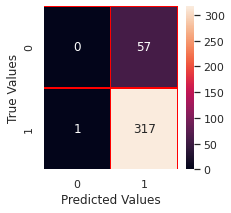

__________________________________
Train set evaluation:
_____________________________________
Validation Accuracy :  0.8333333333333334
Recall: 1.000
Precision: 0.833


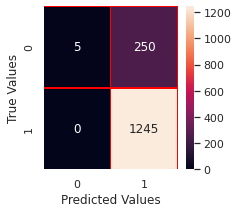

__________________________________


In [160]:
#importing XG Boosting Classifier
from xgboost import XGBClassifier
#fitting data into XG Boosting Classifier
xgb = XGBClassifier()
xgb.fit(X_train,Y_train)

#class prediction of y
y_pred_xgb=xgb.predict(X_test)
y_train_pred_xgb=xgb.predict(X_train)
#getting all scores for XG Boosting Classifier
print('Test set evaluation:\n_____________________________________')
print_evaluate(Y_test, y_pred_xgb)
print('Train set evaluation:\n_____________________________________')
print_evaluate(Y_train, y_train_pred_xgb)


#Model Explainability with shap

In [161]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.5 MB/s 


In [162]:
import shap 
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)


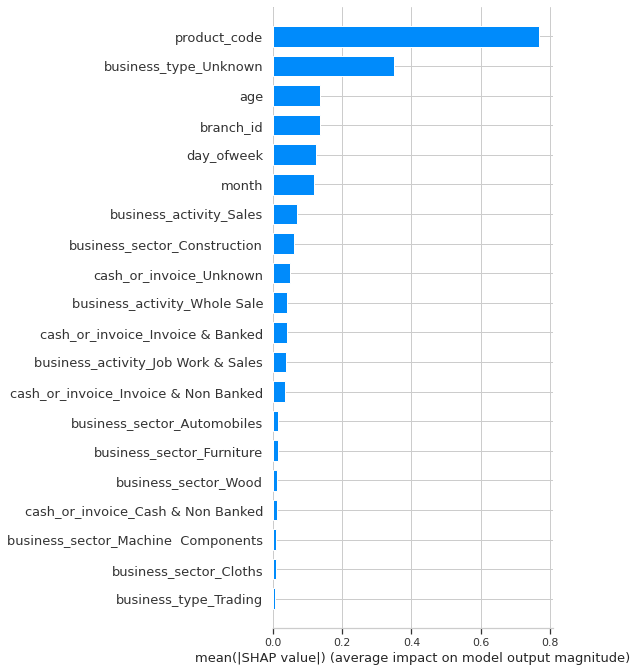

In [163]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

#Conclusion
* With XGBoost as model we are able to get test recall 99% test precision 84%  and test accuracy 84% 
* The scores are pretty hight but they are not completely trustable. Data need more manipulation.
* With more time we can analyse the unknown_business_type which have nulls and filled with values using advance techniques.
*  Also we can analyse the business categories and reshape those which can produce small but effective feature.
* we can try other models as well with hyperparameter tuning and compare the results and important features. 
* Features Like Product code,unknown_business_type, age,month and branch_id plays important role in classifying customer cibil score as above or below the threshold.
* Branch_id's 37,35,15,28 are performing better than others.
* Customers are coming for the loan more than one time but this ratio to new customers is very less.
* There are customers whose loan is rejected as they don't have an account number but have a cibil score above the threshold value of 650 need to work on them.
